# Проект: вариант 2

## Задание 1. A/B–тестирование

### 1.1 Условие

>Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

#### 1.2 Входные данные

>В качестве входных данных вы имеете 4 csv-файла:

>- groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

>- groups_add.csv – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

>- active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

>- checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [1]:
# Импорт библиотек.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import scipy.stats as stats
import requests
from urllib.parse import urlencode

%matplotlib inline

In [2]:
# Ссылки на датасеты.

groups_url = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_url = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_url = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_url = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

# Функция для чтения через API Я.Диска.

def ydisk_api(public_key: str) -> str:
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(url)
    download = response.json()['href']
    return download

In [3]:
# Читаем файлы.

active_studs = pd.read_csv(ydisk_api(active_studs_url))
checks = pd.read_csv(ydisk_api(checks_url), sep=';')
group_add = pd.read_csv(ydisk_api(groups_add_url))
groups = pd.read_csv(ydisk_api(groups_url), sep=';')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Предварительный анализ данных(EDA)

In [4]:
# Проверим корректность считывания и проведем предварительный анализ.
# Файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

active_studs.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [5]:
# Файл с информацией об оплатах пользователей в дни проведения эксперимента. 

checks.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [6]:
# Файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе(А – контроль, B – целевая группа).

groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [7]:
# Дополнительный файл с пользователями, присланный спустя 2 дня после передачи данных.

group_add.head(3)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


In [8]:
# Проверка типов.

checks.dtypes, active_studs.dtypes

(student_id      int64
 rev           float64
 dtype: object,
 student_id    int64
 dtype: object)

In [9]:
# Проверка типов.

groups.dtypes, group_add.dtypes

(id      int64
 grp    object
 dtype: object,
 id      int64
 grp    object
 dtype: object)

In [10]:
# Проверка количества строк и полей.

active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [11]:
# Проверка количества строк и полей.

checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [12]:
# Проверка количества строк и полей.

groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [13]:
# Проверка количества строк и полей.

group_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


Теперь проверим null значения и дубликаты

In [14]:
# Проверим null и дубликаты в groups и остальных датасетах.

groups.duplicated(subset=['id']).sum(), groups.isna().sum()

(0,
 id     0
 grp    0
 dtype: int64)

In [15]:
group_add.duplicated(subset=['id']).sum(), group_add.isna().sum()

(0,
 id     0
 grp    0
 dtype: int64)

In [16]:
active_studs.duplicated().sum(), active_studs.isna().sum()

(0,
 student_id    0
 dtype: int64)

In [17]:
checks.duplicated().sum(), checks.isna().sum()

(0,
 student_id    0
 rev           0
 dtype: int64)

И приведем поля таблиц к одинаковым именам

In [18]:
# Оставим только 'id' как в groups и group_add.

active_studs.rename(columns={'student_id': 'id'}, inplace=True)

checks.rename(columns={'student_id': 'id'}, inplace=True)

**Данные в порядке, тип менять не нужно, можно работать**

In [19]:
# Соберем данные.

# group_full Данные о принадлежности к группам.
group_full = pd.concat([groups, group_add], ignore_index=True)


# Постараемся не удлинять, а сокращать названия переменных. studs подразумевает защедших во время эксперимента
# Пользователей, состоящих в A или B группах.
studs = active_studs.merge(group_full, on='id', how='inner')

# paids таблица платящих пользователей, участвующих в эксперименте.
paids = studs.merge(checks, on='id', how='inner')


paids.head(3)

,id,grp,rev
0,1184303,A,1530.0000
1,3354191,B,1900.0001
2,3278734,B,1900.0000


In [20]:
group_full.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [21]:
studs.head(3)

,id,grp
0,581585,A
1,5723133,A
2,3276743,B


Итого у нас получается 3 датасета

- `group_full` = id студентов и их принадлежность к группе A/B теста

- `studs` = заходили во время эксперимента плюс принадлежность к группе

- `paids` = заходили во время эксперимента и платили

Для исследования нам понадобятся только `studs` и `paids`. Учитывать пользователей, которые не были активны во время эксперимента нет смысла.

B    0.80298
A    0.19702
Name: grp, dtype: float64

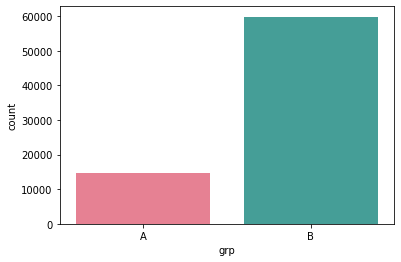

In [22]:
# Посмотрим на соотношение количества студентов в группах.

sns.countplot(x='grp', 
              data=group_full,
              order=['A', 'B'],
              palette='husl')

group_full.grp.value_counts(normalize=True)

Соотношение практически 20 на 80%. Большой перекос в группе B.

B    0.81561
A    0.18439
Name: grp, dtype: float64

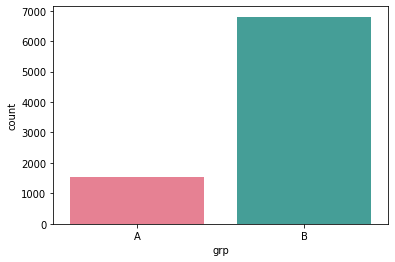

In [23]:
# Посмотрим соотношение в уже объединенных данных.

sns.countplot(x='grp', 
              data=studs,
              order=['A', 'B'],
              palette='husl')


studs.grp.value_counts(normalize=True)

B    0.80102
A    0.19898
Name: grp, dtype: float64

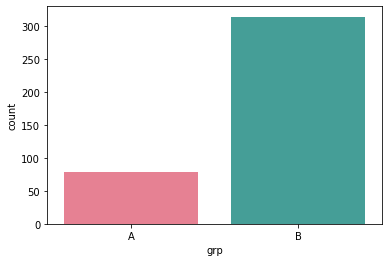

In [24]:
# И в платящих.

sns.countplot(x='grp', 
              data=paids,
              order=['A', 'B'],
              palette='husl')


paids.grp.value_counts(normalize=True)

In [25]:
paids.shape

(392, 3)

**Соотношения практически совпадают во всех датасетах. Финальный датасет `paids` меньше, чем `checks`(541 у `checks` против 392 у `paids`) это значит 149 платящих клиентов не заходили во время эксперимента(тестируется оплата, вероятно, у оставшихся настроен автоплатеж. Или просто баг, в любом случае для исследования механики оплаты учитывать их нет смысла).**

Возникает вопрос о причинах такого перекоса, проблема ли это сплитования, баги или ещё что-то, мы не знаем, хотя соотношения почти везде 80% на 20%, наталкивает на мысль, что проблема в автоматике. Но количество наблюдений большое, это позволяет нам продолжить исследование и проводить статистические тесты.

Прежде чем переходить к метрикам исследуем получившиеся данные немного глубже.

In [26]:
# Из-за перекоса в группах суммы в них нам ничего не дают, но для общего понимания можно посмотреть.

paids.groupby('grp')['rev'].sum()

grp
A     72820.0000
B    394974.0035
Name: rev, dtype: float64

In [27]:
# Среднее и медиана более информативны, но и на них перекос группы B(тестовая)

paids.groupby('grp')['rev'].mean()

grp
A     933.589744
B    1257.878992
Name: rev, dtype: float64

In [28]:
paids.groupby('grp')['rev'].median()

grp
A     585.0
B    1140.0
Name: rev, dtype: float64

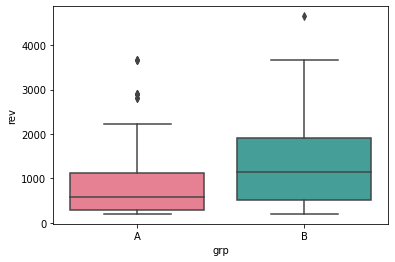

In [29]:
# Boxplot наглядно показывает эти различия. 
    
sns.boxplot(data = paids,
            x = 'grp',
            y = 'rev',
            palette='husl')

Различия действительно есть. Распределение не назвать нормальным(ниже докажем статистически). Значительная разница между средним арифметическим значением и медианой в группе A указывает на выбросы в данных. Они действительно видны на графике.

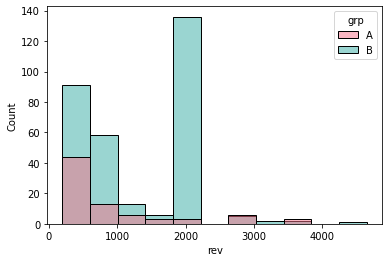

In [30]:
sns.histplot(x='rev', 
              data=paids,
              hue='grp',
              palette='husl')

# Интересно что на графике видно, что после 2000 соотношение немного меняется.

B    0.6
A    0.4
Name: grp, dtype: float64

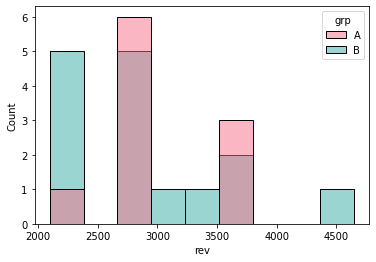

In [31]:
# Количество и соотношение в группах при чеке выше 2000. 

sns.histplot(x='rev', 
              data=(paids[paids["rev"] > 2000]),
              hue='grp',
              palette='husl')

(paids[paids["rev"] > 2000]).grp.value_counts(normalize=True)

In [32]:
(paids[paids["rev"] > 2000]).groupby('grp')['id'].count()

grp
A    10
B    15
Name: id, dtype: int64

Серьезных статистических выводов при таком N мы делать не можем. Можно лишь отметить тенденцию что соотношение в группах начинает меняться при rev > 2000.

# 1.3 Вопросы

> - ### На какие метрики вы смотрите в ходе анализа и почему?

> - ### Имеются ли различия в показателях и с чем они могут быть связаны?

> - ### Являются ли эти различия статистически значимыми?

> - ### Стоит ли запускать новую механику на всех пользователей?

# На какие метрики опираться и почему. CR, ARPU, ARPPU.

### Почему?

Так как мы исследуем механику оплаты, логично выбрать метрики, отражающие то, как часто пользователи платят и сколько платят. 
CR — конверсия в оплаты. Если новая механика позволяет принять решение о покупке, то эта метрика отразит изменение.
ARPU(Средний доход на пользователя) и ARPPU(Средний доход на платящего пользователя) — если механика оплаты улучшает пользовательский опыт, то они могут начать тратить больше. Эти метрики отразят это изменение.

# CR

**Первой возьмем метрику CR. Конверсия в оплату из захода на сайт. Так как мы тестируем оплату, конверсия будет важным показателем.**

In [33]:
# У нас есть датафрейм studs = заходили во время эксперимента плюс принадлежность к группе и
# paids = заходили во время эксперимента и платили.
# Объединим их и получим таблицу с заходившими во время эксперимента пользователями которые платили\не платили.

# Для начала добавим колонку в paid с обозначением оплаты.
paids['paid'] = 1

cr = studs.merge(paids[['id', 'rev', 'paid']], on='id', how='left').fillna(0)

# cr новый объединенный датафрейм для расчета конверсии. Включает в себя всех пользователей, заходивших во время эксперимента
# с маркером платящих\не платящих.
cr.head(3)

,id,grp,rev,paid
0,581585,A,0.0,0.0
1,5723133,A,0.0,0.0
2,3276743,B,0.0,0.0


In [34]:
# Посмотрим на распределение.

cr_value = cr.groupby('grp').paid.value_counts()

cr_value

grp  paid
A    0.0     1460
     1.0       78
B    0.0     6489
     1.0      314
Name: paid, dtype: int64

In [35]:
# Рассчитываем конверсию (CR) как долю оплативших в каждой группе.

cr_prc = cr.groupby('grp')['paid'].mean()

cr_prc.round(4)

grp
A    0.0507
B    0.0462
Name: paid, dtype: float64

**Конверсия в группе A ≈ 5.07%. В группе B ≈ 4.62%.** 

Чтобы проверять статистическую значимость результатов возьмем χ2 так как сравниваются категории. Размер выборки достаточно большой и наблюдения независимы. Можем быть уверенными в точности теста.

H₀ — конверсии в группах A и B статистически не различаются

H₁ — разница конверсий статистически значима

In [36]:
# Распределим значения по переменным для χ2.

grp_A = cr[cr['grp'] == 'A']
grp_B = cr[cr['grp'] == 'B']

A_pay = grp_A.paid.sum()
A_nopay = grp_A.paid.size - grp_A.paid.sum()

B_pay = grp_B.paid.sum()
B_nopay = grp_B.paid.size - grp_B.paid.sum()

In [37]:
# Создадим матрицу значений.

matrix = np.array([[A_pay, A_nopay],
                   [B_pay, B_nopay]])

matrix

array([[  78., 1460.],
       [ 314., 6489.]])

In [38]:
stats.chi2_contingency(matrix, correction=False)[1]

0.44547028437158964

Результаты статистических тестов:
**χ2 p-value = 0.4454 (> 0.05)**

**Оставляем H₀, различие в конверсии в покупку между группами A и B не является статистически значимым.**

# СR Вывод:

**Несмотря на то, что группа A показывает чуть более высокую конверсию, статистические тесты не подтверждают значимого различия.
Нет оснований утверждать, что одно из условий эксперимента повлияло на конверсию. То есть мы можем заявить, что новая механика не влияет на принятие решения о покупке.**

# ARPU(Средний доход на пользователя) и ARPPU(Средний доход на платящего пользователя)


Другими важными метриками являются **ARPU**(Средний доход на пользователя) и **ARPPU**(Средний доход на платящего пользователя). Если новая механика оплаты не влияет на принятие решения о покупке, возможно, она влияет на средний чек покупки(например, если каждый товар не надо оплачивать отдельно).

`cr` — активные пользователи, этот датафрейм подойдет для вычисления **ARPU**

`paids` — активные платящие пользователи, этот датафрейм подойдет для вычисления **ARPPU**

In [39]:
# Первым рассчитаем ARPU.

arpu_values = cr.groupby("grp")["rev"].mean()  # Средний доход на всех пользователей.

arpu_values

grp
A    47.347204
B    58.058798
Name: rev, dtype: float64

In [40]:
#Теперь ARPPU.

arppu_values = paids.groupby("grp")["rev"].mean()  # Средний доход только на платящих.

arppu_values

grp
A     933.589744
B    1257.878992
Name: rev, dtype: float64

В обоих случаях у группы B преимущество. Необходимо проверить данные на статистическую значимость. Для этого сначала нужно исследовать нормальность распределения и дисперсии в `paids` и `cr` датафреймах.

### Нормальность данных

Убедимся в том, что данные распределены не нормально. Выборка в `paids` A = 78, B = 314, при таком размере можем воспользоваться классическим для проверки нормальности тестом Шапиро-Уилка. Выборка `cr` A = 1538, B = 6803. При N > 500 будет более резонным воспользоваться тестом Андерсона-Дарлинга так как он лучше ведет себя на больших выборках. Таким образом для `paids` будем использовать тест Шапиро-Уилка. Для `cr` тест нормальности Андерсона-Дарлинга. 


Нулевая гипотеза (H₀) для теста Шапиро-Уилка для `paids`:

- Данные о доходах (rev) в каждой группе (A и B) распределены нормально.

То есть, выборки из групп A и B следуют нормальному распределению.

Альтернативная гипотеза (H₁):
- Данные не соответствуют нормальному распределению.


In [41]:
# Тест Шапиро-Уилка на нормальность.
shapiro_A = stats.shapiro(paids[paids["grp"] == "A"]["rev"])
shapiro_B = stats.shapiro(paids[paids["grp"] == "B"]["rev"])

shapiro_A, shapiro_B

(ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10),
 ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16))

Оба p-value << 0.05, поэтому мы отвергаем нулевую гипотезу и заключаем, что распределения в группах A и B в `paids` не являются нормальными.

Исследуем `cr` на нормальность. 

Нулевая гипотеза (H₀) для теста Андерсона-Дарлинга:

- Данные о доходах (rev) в каждой группе (A и B) распределены нормально.

Альтернативная гипотеза (H₁):

- Данные не соответствуют нормальному распределению.

In [42]:
# Фильтруем данные по группам A и B
data_A = cr[cr['grp'] == 'A']['rev']
data_B = cr[cr['grp'] == 'B']['rev']


# Тест Андерсона-Дарлинга для группы B
pg.normality(data_B, method='normaltest')

,W,pval,normal
rev,7797.399212,0.0,False


In [43]:
# Тест Андерсона-Дарлинга для группы A

pg.normality(data_A, method='normaltest')

,W,pval,normal
rev,2240.595797,0.0,False


Распределение не является нормальным. Мы отвергаем H₀ и принимаем H₁: **Данные в группах A и B в `cr` не соответствуют нормальному распределению.**

### Дисперсии внутри групп

Однако, пока мы не знаем дисперсий внутри групп, это критичный параметр для выбора статистического теста.  Группы независимы, данные (rev) количественные, наблюдений достаточно. Можем применять тест Левена. Гипотезы теста Левена для `paids`: 

- H₀: Дисперсии во группах A и B равны. (группы имеют одинаковую вариативность).

- H₁: Дисперсии различны (группы имеют разную вариативность).

In [44]:
# Проверяем дисперсию внутри групп A и B с помощью теста Левена.

levene_test = stats.levene(
    paids[paids["grp"] == "A"]["rev"],
    paids[paids["grp"] == "B"]["rev"]
)

levene_test


LeveneResult(statistic=3.0756816999816055, pvalue=0.08025675761347022)

Так как 𝑝 > 0.05 мы **не отвергаем нулевую гипотезу** о равенстве дисперсий. 
Это значит, что различие в дисперсиях между группами не является статистически значимым и мы можем использовать T-тест.

Тест Левена для `cr`:

- H₀: Дисперсии данных о доходах (rev) в каждой группе (A и B) `cr` не отличаются.

- H₁: Дисперсии статистически различаются.

In [45]:
# Проверяем дисперсию внутри групп A и B с помощью теста Левена.

levene_test_cr = stats.levene(
    data_A,
    data_B
)

levene_test_cr

LeveneResult(statistic=1.5014608294336371, pvalue=0.22048133327049665)

**pvalue > 0.05. Оставляем H₀ — дисперсии не имеют статистически значимых различий.**

Нужно проверить статистическую значимость. Для ARPU и ARPPU воспользуемся Т-критерием Стьюдента о различии средних. Несмотря на ненормальность данных дисперсии внтри групп статистически не различаются и размеры выборок большие.

- H₀ для ARPU — при новой механике средний доход от пользователя не изменился;

- H₁ для ARPU — при новой механике средний доход от пользователя статистически значимо изменился.


- H₀ для ARPPU — при новой механике средний доход от платящего пользователя не изменился;

- H₁ для ARPPU — при новой механике средний доход от платящего пользователя статистически значимо изменился.

In [46]:
# T-тест для ARPU и ARPPU.
t_stat_arpu = stats.ttest_ind(
    cr[cr["grp"] == "A"]["rev"],
    cr[cr["grp"] == "B"]["rev"]
)

t_stat_arppu = stats.ttest_ind(
    paids[paids["grp"] == "A"]["rev"],
    paids[paids["grp"] == "B"]["rev"]
)

t_stat_arpu, t_stat_arppu

(Ttest_indResult(statistic=-1.225341107379344, pvalue=0.22048133326988403),
 Ttest_indResult(statistic=-3.1337795050930985, pvalue=0.0018562025265765867))

### ARPU имеет pvalue = 0.22 — разница незначима. ARPPU pvalue = 0.002. ARPPU имеет статистически значимую разницу.

#### - ARPU: оставляем H₀. при новой механике средний доход от пользователя не изменился.

#### - ARPPU: принимаем H₁. при новой механике средний доход от платящего пользователя статистически значимо изменился.

In [47]:
# Каждый id уникален. Это значит, что средний чек увеличился за счет увеличения чека, а не повторных покупок.
# На это указывает одинаковое количество строк с исходным датафреймом.

paids.groupby('id').nunique()

,grp,rev,paid
id,,,
1627,1,1,1
100300,1,1,1
108270,1,1,1
264473,1,1,1
274352,1,1,1
...,...,...,...
5645737,1,1,1
5651566,1,1,1
5662322,1,1,1


In [48]:
paids.shape

(392, 4)

**ARPPU и ARPPU вывод:**

Результаты теста не оказывают на ARPU(Средний доход на пользователя) статистически значимого влияния.

Однако разница в ARPPU(Средний доход на платящего пользователя) является статистически значимой. Вывод по этим показателям сходится с выводом по CR(тестируемая механика не влияет на принятие решения о покупке).

Логично, что на средний доход пользователя тест тоже не повлиял. Однако повлиял на доход среди уже платящих пользователей.

В случае ARPPU мы отвергаем нулевую гипотезу, разница среднего дохода на платящего пользователя статистически значима.

# Общий вывод

- **Конверсия в группе A ≈ 5.07%. В группе B ≈ 4.62%. Различия не имеют статистической значимости(χ2).**

- **Средний доход на пользователя в группе A = 47.3. В группе B = 58.1. Различия не имеют статистической значимости(T-тест).**

- **Средний доход на платящего пользователя в группе A = 933.6. В группе B = 1257.9. Различия статистически значимы(T-тест).**

**Рост ARPPU обусловлен увеличением суммы одной покупки. В датасете каждый id уникален.**

### Рекомендация по запуску на всех пользователей:

**На основе этих результатов целесообразно внедрить новую механику оплаты для всех пользователей. Поскольку новая система «как минимум не делает хуже» ключевые метрики, рисков особых нет. А заметное увеличение среднего чека среди платящих – это положительный результат для выручки.**

#### Особенно если бизнесу важно повысить доход с транзакции (ARPPU), то новая механика явно полезна. 
#### Даже при неизменной конверсии, рост среднего чека в группе B приводит к росту выручки на пользователя (хоть и статистически незначимому в этой выборке, тренд позитивный). 
#### Можно ожидать, что на больших масштабах общий доход увеличится. Исключение может быть, если бы основной целью была именно максимизация конверсии любой ценой – тогда стоило бы учесть, что конверсия не выросла. Но так как она и не упала значимо, внедрение не повредит и этому показателю.

# Задание 2. SQL

## 2.1 Очень усердные ученики.

### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

### Дана таблица peas вида:

![peas](https://sun9-59.userapi.com/impg/t0annIK45CBYRe76XM4fI7yuVolGGNa4Za5-gQ/CWYN6ms2KL0.jpg?size=814x233&quality=95&sign=d41ab9233f7c4629e01e01fdd5be6a27&type=album)

# SQL код запроса

```
SELECT COUNT(1) AS very_diligent_students
FROM (
    SELECT st_id
    FROM peas
    WHERE correct = TRUE
    GROUP BY st_id
    HAVING COUNT(*) >= 20 -- 20 и более правильных ответов
) AS sub;

```

>Выдача по запросу: very_diligent_students 136	

## 2.2 Оптимизация воронки

### 2.2.1 Условие

>Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

### 2.2.2 Задача

>Даны таблицы: peas(cм. выше), studs и final_project_check

![studs](https://sun9-4.userapi.com/impg/NjHxVOErcQ1qXs5gvaUezBxc1vtJ5yjsldmiOQ/A91FB5MNUnc.jpg?size=806x370&quality=95&sign=b7aec5779c266096296e9f89159d78bd&type=album)

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
- ARPU считается относительно всех пользователей, попавших в группы.

- Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

- Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

```
SELECT 
    tests.test_grp AS "group",     
    -- ARPU: средняя выручка на пользователя
    ROUND(
        SUM(final_project_check.money) 
        / NULLIF(COUNT(DISTINCT tests.st_id), 0)::numeric,
    2) AS ARPU,     

    -- ARPAU: средняя выручка на активного пользователя (>10 правильных решений)
    ROUND(
        SUM(CASE WHEN active_info.total_correct > 10 THEN final_project_check.money END) 
        / NULLIF(
            COUNT(DISTINCT CASE WHEN active_info.total_correct > 10 THEN active_info.st_id END),
        0)::numeric,
    2) AS ARPAU,       

    -- CR_total_user: конверсия в покупку среди всех пользователей
    ROUND(
        COUNT(DISTINCT CASE WHEN final_project_check.money > 0 THEN final_project_check.st_id END) * 100.0
        / NULLIF(COUNT(DISTINCT tests.st_id), 0),
    2) AS CR_total_user,     

    -- CR_active_user: конверсия в покупку среди активных пользователей (>10 правильных решений)
    ROUND(
        COUNT(DISTINCT CASE WHEN final_project_check.money > 0 AND active_info.total_correct > 10 THEN final_project_check.st_id END) * 100.0
        / NULLIF(
            COUNT(DISTINCT CASE WHEN active_info.total_correct > 10 THEN active_info.st_id END),
        0),
    2) AS CR_active_user,     

    -- CR_math_user: конверсия в покупку по math среди "математически активных" (≥2 правильных по math)
    ROUND(
        COUNT(DISTINCT CASE WHEN final_project_check.money > 0 
                                 AND final_project_check.subject = 'Math'
                                 AND active_info.math_correct >= 2
                            THEN final_project_check.st_id 
                       END
        ) * 100.0
        / NULLIF(
            COUNT(DISTINCT CASE WHEN active_info.math_correct >= 2 THEN active_info.st_id END),
        0),
    2) AS CR_math_user 

FROM studs AS tests 
LEFT JOIN final_project_check AS final_project_check 
    ON tests.st_id = final_project_check.st_id 
LEFT JOIN (
    SELECT 
        st_id, 
        -- Считаем общее число верно решённых задач (по всем предметам)
        SUM(CASE WHEN correct THEN 1 ELSE 0 END) AS total_correct,         
        -- Считаем число верно решённых задач по математике
        SUM(CASE WHEN subject = 'Math' AND correct THEN 1 ELSE 0 END) AS math_correct
    FROM peas
    GROUP BY st_id
) AS active_info         
    ON tests.st_id = active_info.st_id 
GROUP BY tests.test_grp;
```

Соберем в датафрейм для наглядности.

In [49]:
data = {
    "group": ["control", "pilot"],
    "arpu": [4540.98, 11508.47],
    "arpau": [10393.70, 29739.58],
    "cr_total_user": [4.92, 10.85],
    "cr_active_user": [11.02, 26.04],
    "cr_math_user": [6.12, 9.52]
}

df = pd.DataFrame(data)

df

,group,arpu,arpau,cr_total_user,cr_active_user,cr_math_user
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


# Задание 3. Python

## 3.1 Задача

3.1.1 Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [50]:
def load_data(url: str, sep: str) -> pd.DataFrame:
    """
    Загружает данные по публичному URL из Yandex Disk.
    
    Параметры:
      url: Строка с публичной ссылкой на файл.
      sep: Разделитель для чтения CSV-файла.
      
    Возвращает:
      DataFrame с данными. Если столбец 'id' отсутствует, но есть 'student_id',
      он переименовывается в 'id'.
    """
    # Формирование запроса к API Yandex Disk с использованием urlencode для корректного формирования параметров.
    api_path = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    full_url = api_path + urlencode({'public_key': url})
    
    # Выполняем GET-запрос и проверяем успешность ответа.
    response = requests.get(full_url)
    response.raise_for_status()  # Если статус ошибки, выбросится исключение.
    
    # Извлекаем URL для скачивания файла.
    download_url = response.json().get('href')
    if not download_url:
        raise ValueError("Не удалось получить URL для скачивания")
    
    # Чтение CSV-файла по полученному URL.
    df = pd.read_csv(download_url, sep=sep)
    
    # Если столбец 'id' отсутствует, но присутствует 'student_id', переименовываем его.
    if 'id' not in df.columns and 'student_id' in df.columns:
        df.rename(columns={'student_id': 'id'}, inplace=True)
    
    return df

def update_metrics(public_keys: dict) -> pd.DataFrame:
    """
    Загружает данные, объединяет их и рассчитывает метрики.
    
    Параметры:
      public_keys: Словарь, где каждому ключу соответствует список из [URL, разделитель].
      
    Возвращает:
      DataFrame с рассчитанными метриками:
        - user_count: количество пользователей,
        - payds_count: количество пользователей, совершивших платеж,
        - revenue: суммарный доход,
        - CR: конверсия в процентах,
        - ARPU: доход на пользователя,
        - ARPPU: доход на платящего пользователя.
    """
    # Загрузка данных из разных источников.
    groups = load_data(public_keys['groups'][0], public_keys['groups'][1])
    groups_add = load_data(public_keys['groups_add'][0], public_keys['groups_add'][1])
    active_studs = load_data(public_keys['active_studs'][0], public_keys['active_studs'][1])
    checks = load_data(public_keys['checks'][0], public_keys['checks'][1])
    
    # Объединение групп в один DF.
    groups_full = pd.concat([groups, groups_add], ignore_index=True)
    
    # Объединение активных студентов с данными проверок по столбцу 'id'.
    active_studs = active_studs.merge(checks, how='left', on='id').fillna(0)
    
    # Объединение активных студентов с информацией о группах.
    final_df = active_studs.merge(groups_full, how='left', on='id')
    
    # Добавление булевого столбца 'paid', который True, если 'rev' > 0.
    final_df['paid'] = final_df['rev'] > 0
    
    # Группировка по'grp' и расчет агрегированных метрик.
    result = final_df.groupby('grp').agg(
        user_count=('id', 'count'),      # Количество пользователей.
        payds_count=('paid', 'sum'),       # Сумма True в столбце 'paid' = количество платежей.
        revenue=('rev', 'sum')             # Суммарный доход.
    )
    
    # Расчет CR в процентах, ARPU и ARPPU с округлением до 2 знаков.
    result['CR'] = round(result['payds_count'] / result['user_count'] * 100, 2)
    result['ARPU'] = round(result['revenue'] / result['user_count'], 2)
    result['ARPPU'] = round(result['revenue'] / result['payds_count'], 2)
    
    return result.reset_index()

public_keys = {}
public_keys['groups'] = ['https://disk.yandex.ru/d/UhyYx41rTt3clQ', ';']
public_keys['groups_add'] = ['https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', ',']
public_keys['active_studs'] = ['https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', ',']
public_keys['checks'] = ['https://disk.yandex.ru/d/pH1q-VqcxXjsVA', ';']

# Вызываем функцию и сохраняем результат в переменную metrics_result
metrics_result = update_metrics(public_keys)

metrics_result

,grp,user_count,payds_count,revenue,CR,ARPU,ARPPU
0,A,1538,78,72820.0000,5.07,47.35,933.59
1,B,6803,314,394974.0035,4.62,58.06,1257.88


3.1.2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [51]:
def showing(metrics_result):   
    sns.set(style="dark")
    
    fig, axs = plt.subplots(ncols=3, figsize=(16, 5))

    sns.barplot(x="grp", y="CR", 
                data=metrics_result,
                ax=axs[0], palette='husl').set(xlabel='Group', ylabel='', title='CR')
    sns.barplot(x="grp", y="ARPU", 
                data=metrics_result,
                ax=axs[1], palette='husl').set(xlabel='Group', ylabel='', title='ARPU')
    sns.barplot(x='grp', y="ARPPU",            
                data=metrics_result,
                ax=axs[2], palette='husl').set(xlabel='Group', ylabel='', title='ARPPU')


    plt.show()

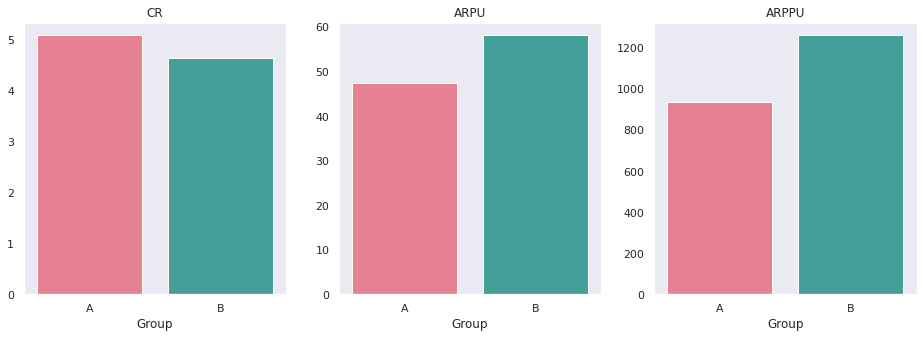

In [52]:
showing(metrics_result)

Fin